In [1]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from sklearn.decomposition import PCA
import warnings
pd.set_option('display.max_columns', 500)

In [2]:
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)


# Specify data locations

In [3]:
#Specify the path to clinical_data_cleaned.csv, which contains clinical features and outcome data
clinical_data_path = "../CSV/clinical_data_KNN.csv"

#Specify the path to the extracted features from KimiaNet
features_path = "../CSV/features_autoencoder_2.csv.csv"

#Specify the path to the extracted features from KimiaNet with clinical data
features_with_clinical_data_path = "../CSV/features_with_clinical_data_1024_V3.csv"

# Select which features to use

In [4]:
#Specify one of the following: "ALL", "EXTRACTED", "CLINICAL"
FEATURES = "ALL"

In [5]:
if FEATURES == "ALL":
    data = features_with_clinical_data_path
elif FEATURES == "EXTRACTED":
    data = features_with_clinical_data_path
else:
    data = clinical_data_path

In [6]:
df_2 = pd.read_csv(clinical_data_path)
if FEATURES == "ALL":
    df = pd.read_csv(data)
    df = df.astype(np.float32)
    df.set_index("patient_id", inplace=True)
    df.drop(["PFS"], inplace=True, axis=1)
elif FEATURES == "EXTRACTED":
    df = pd.read_csv(data)
    df = df.astype(np.float32)
    df.set_index("patient_id", inplace=True)
    df.drop(["PFS", "MYC IHC", "BCL2 IHC", "BCL6 IHC", "CD10 IHC", "MUM1 IHC",
           "HANS", "BCL6 FISH", "MYC FISH", "BCL2 FISH", "Age", "ECOG PS", "LDH",
           "EN", "Stage", "IPI Score", "IPI Risk Group (4 Class)", "RIPI Risk Group"], inplace=True, axis=1)
else:
    df = pd.read_csv(data)
    df = df.astype(np.float32)
    df.set_index("patient_id", inplace=True)
    df.drop(["PFS"], inplace=True, axis=1)
df.rename(columns={"Follow-up Status": "FUS"}, inplace=True)
df

,MYC IHC,BCL2 IHC,BCL6 IHC,CD10 IHC,MUM1 IHC,HANS,BCL6 FISH,MYC FISH,BCL2 FISH,Age,ECOG PS,LDH,EN,Stage,IPI Score,IPI Risk Group (4 Class),RIPI Risk Group,OS,FUS,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,...,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13901.0,0.0,30.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,61.0,2.0,1.0,1.0,4.0,4.0,3.0,2.0,2.78,0.0,0.088093,0.037736,0.072670,0.004785,0.099546,0.255045,0.083281,0.150263,0.241883,0.027969,0.081558,0.022594,0.119703,0.092143,0.000000,0.000216,0.202344,1.022947,0.018109,0.316823,0.145919,0.056664,0.146886,0.101732,0.000000,0.012339,0.009823,0.223968,0.060601,0.190750,0.0,0.006755,0.491230,0.134432,0.738565,0.139892,0.001652,0.005734,0.055238,0.117088,0.005589,0.082005,0.127266,0.048763,0.080887,0.059692,0.036024,0.0,0.009634,0.126621,0.065364,0.0,0.048849,0.072853,0.226485,0.022872,0.311689,0.049483,0.070947,0.033477,0.034217,0.005595,0.022280,0.290725,0.023012,0.002100,0.064875,0.0,0.264879,0.358051,0.000315,0.122812,0.166075,0.000000,0.107746,0.002175,0.001691,0.0,0.037588,0.042308,0.159961,0.010067,0.200958,0.208882,0.402937,0.150299,0.0,0.189063,0.046558,1.389428,0.013086,0.619280,0.013231,0.013973,0.189278,0.0,0.000000,0.064453,1.300687,0.0,1.336252,0.074797,0.173977,0.246987,0.459042,0.004806,0.733700,0.001035,0.036308,0.000852,0.068517,0.097168,0.035119,0.0,0.099086,0.0,0.214465,0.0,0.116575,0.0,0.006765,0.0,0.000000,0.198460,0.0,0.023909,0.254417,1.258944,0.014116,0.160640,0.196989,0.588524,0.064112,0.111381,0.0,0.802961,0.0,0.011336,0.798834,1.109761,0.001843,0.033876,0.003285,1.908105,0.001588,0.036078,0.070532,0.269694,0.231560,0.034171,0.008478,0.113079,0.937154,0.077610,0.694597,0.053736,0.075270,0.0,0.267279,0.107589,0.0,0.235049,1.131417,0.044185,0.000000,0.

In [ ]:
df.describe()

In [7]:
# Rename columns 0, 1, 2, ..., 1023 to "C0", "C1", "C2", ..., "C1023"
if FEATURES == "ALL":
    last_cols = ["C" + str(i) for i in range(df.shape[1]-19)]
    #last_cols = [str(i) for i in range(df.shape[1]-19)]
    first_cols = ['MYC IHC', 'BCL2 IHC', 'BCL6 IHC', 'CD10 IHC', 'MUM1 IHC',
           'HANS', 'BCL6 FISH', 'MYC FISH', 'BCL2 FISH', 'Age', 'ECOG PS', 'LDH',
           'EN', 'Stage', 'IPI Score', 'IPI Risk Group (4 Class)', 'RIPI Risk Group', 'OS', 'FUS']
elif FEATURES == "EXTRACTED":
    last_cols = ["C" + str(i) for i in range(df.shape[1]-2)]
    first_cols = ['OS', 'FUS']
else:
    last_cols = []
    first_cols = ['MYC IHC', 'BCL2 IHC', 'BCL6 IHC', 'CD10 IHC', 'MUM1 IHC',
           'HANS', 'BCL6 FISH', 'MYC FISH', 'BCL2 FISH', 'Age', 'ECOG PS', 'LDH',
           'EN', 'Stage', 'IPI Score', 'IPI Risk Group (4 Class)', 'RIPI Risk Group', 'OS', 'FUS']
cols = first_cols + last_cols
df.columns = cols

In [8]:
# Drop all the columns with a variance of 0
final_df = df.loc[:, (df != df.iloc[0]).any()]
final_df


,MYC IHC,BCL2 IHC,BCL6 IHC,CD10 IHC,MUM1 IHC,HANS,BCL6 FISH,MYC FISH,BCL2 FISH,Age,ECOG PS,LDH,EN,Stage,IPI Score,IPI Risk Group (4 Class),RIPI Risk Group,OS,FUS,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C87,C88,C89,C90,C91,C92,C93,C94,C96,C97,C98,C100,C101,C102,C103,C104,C105,C106,C107,C108,C109,C110,C111,C112,C114,C116,C117,C118,C120,C122,C123,C125,C126,C127,C128,C129,C130,C131,C132,C133,C135,C137,C138,C139,C140,C141,C142,C143,C144,C145,C146,C147,C148,C149,C150,C151,C152,C153,C154,C155,C156,C157,C158,C159,C161,C162,C163,C164,C166,C169,C170,C171,C172,C173,C176,C177,C178,C179,C180,C182,C183,C185,C188,C189,C190,C191,C192,C193,C194,C195,C196,C197,C198,C199,C200,C201,C202,C203,C204,C205,C207,C208,C209,C210,C212,C213,C214,C215,C216,C217,C218,C219,C220,C221,C222,C223,C224,C225,C226,C227,C228,C230,C231,C232,C233,C234,C235,C236,C239,C241,C242,C243,C246,C247,C249,C250,C251,C252,C253,C254,C255,C256,C257,C258,C259,C260,C261,C262,...,C774,C775,C776,C777,C778,C779,C780,C781,C782,C783,C784,C785,C786,C787,C788,C789,C790,C791,C792,C793,C794,C795,C796,C797,C798,C799,C800,C801,C802,C803,C804,C805,C806,C807,C808,C809,C810,C811,C812,C813,C814,C815,C816,C817,C818,C819,C820,C821,C822,C823,C824,C825,C826,C827,C828,C829,C830,C831,C832,C833,C834,C835,C836,C837,C838,C839,C840,C841,C842,C843,C844,C845,C846,C847,C848,C849,C850,C851,C852,C853,C854,C855,C856,C857,C858,C859,C860,C861,C862,C863,C864,C865,C866,C867,C868,C869,C870,C871,C872,C873,C874,C875,C876,C877,C878,C879,C880,C881,C882,C883,C884,C885,C886,C887,C888,C889,C890,C891,C892,C893,C894,C895,C896,C897,C898,C899,C900,C901,C902,C903,C904,C905,C906,C907,C908,C909,C910,C911,C912,C913,C914,C915,C916,C917,C918,C919,C920,C921,C922,C923,C924,C925,C926,C927,C928,C929,C930,C931,C932,C933,C934,C935,C936,C937,C938,C939,C940,C941,C942,C943,C944,C945,C946,C947,C948,C949,C950,C951,C952,C953,C954,C955,C956,C957,C958,C959,C960,C961,C962,C963,C964,C965,C966,C967,C968,C969,C970,C971,C972,C973,C974,C975,C976,C977,C978,C979,C980,C981,C982,C983,C984,C985,C986,C987,C988,C989,C990,C991,C992,C993,C994,C995,C996,C997,C998,C999,C1000,C1001,C1002,C1003,C1004,C1005,C1006,C1007,C1008,C1009,C1010,C1011,C1012,C1013,C1014,C1015,C1016,C1017,C1018,C1019,C1020,C1021,C1022,C1023
patient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13901.0,0.0,30.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,61.0,2.0,1.0,1.0,4.0,4.0,3.0,2.0,2.78,0.0,0.088093,0.037736,0.072670,0.004785,0.099546,0.255045,0.083281,0.150263,0.241883,0.027969,0.081558,0.022594,0.119703,0.092143,0.000000,0.000216,0.202344,1.022947,0.018109,0.316823,0.145919,0.056664,0.146886,0.101732,0.000000,0.012339,0.009823,0.223968,0.060601,0.190750,0.006755,0.491230,0.134432,0.738565,0.139892,0.001652,0.005734,0.055238,0.117088,0.005589,0.082005,0.127266,0.048763,0.080887,0.059692,0.036024,0.009634,0.126621,0.065364,0.0,0.048849,0.072853,0.226485,0.022872,0.311689,0.049483,0.070947,0.033477,0.034217,0.005595,0.022280,0.290725,0.023012,0.002100,0.064875,0.264879,0.358051,0.000315,0.122812,0.166075,0.000000,0.107746,0.002175,0.001691,0.0,0.037588,0.042308,0.159961,0.010067,0.200958,0.208882,0.402937,0.150299,0.189063,0.046558,1.389428,0.013086,0.619280,0.013231,0.013973,0.189278,0.000000,0.064453,1.300687,1.336252,0.074797,0.173977,0.246987,0.459042,0.004806,0.733700,0.001035,0.

In [9]:
def PCAMethod(df, n_feats):
    new_df = df[last_cols]
    pca = PCA(n_components=n_feats)
    pca.fit(new_df)
    pca_transformed = pca.transform(new_df)
    pca_df = pd.DataFrame(data=pca_transformed, columns=['PC{}'.format(i+1) for i in range(n_feats)])
    final_df = np.hstack((df[first_cols], pca_df))
    final_df= pd.DataFrame(final_df, columns=list(df[first_cols].columns) + list(pca_df.columns))
    return final_df

In [10]:
final_df = PCAMethod(df, 128)
final_df

,MYC IHC,BCL2 IHC,BCL6 IHC,CD10 IHC,MUM1 IHC,HANS,BCL6 FISH,MYC FISH,BCL2 FISH,Age,ECOG PS,LDH,EN,Stage,IPI Score,IPI Risk Group (4 Class),RIPI Risk Group,OS,FUS,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125,PC126,PC127,PC128
0,0.0,30.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,61.0,2.0,1.0,1.0,4.0,4.0,3.0,2.0,2.78,0.0,-6.382411,2.140683,1.155160,-0.991517,-1.358541,-1.740273,0.706927,-2.029642,0.620379,-0.104029,0.820845,0.133173,-0.167722,0.509293,0.287630,0.064325,0.041390,0.738907,-0.294617,0.112478,-0.860732,0.011816,0.519465,0.502119,0.719591,0.157325,-0.096023,0.077404,-0.028091,-0.582522,0.190812,-0.487053,0.188387,0.593695,0.135642,0.213734,0.140589,0.011753,0.037594,-0.070286,0.171096,-0.198709,-0.220109,0.193242,-0.133894,-0.223528,0.127969,-0.018033,-0.094610,0.207318,0.213206,-0.248542,-0.133448,-0.110227,0.045800,-0.323677,0.036730,0.105972,-0.070194,0.168457,0.117261,-0.224570,-0.091299,0.325446,-0.016412,0.122054,-0.080057,-0.211585,-0.245575,-0.089980,-0.016050,-0.074973,0.060090,-0.223798,-0.157758,-0.045469,-0.227698,0.117556,0.001652,-0.156022,-0.260598,-0.015053,0.109029,-0.007092,-0.222723,0.088757,0.107952,-0.084708,0.090619,-0.169130,0.187268,0.315565,-0.071346,-0.077384,-0.029814,-0.017641,-0.046075,0.159761,0.068492,-0.277537,-0.008229,0.148152,-0.002861,0.062993,0.026068,-0.193393,-0.005943,0.038211,-0.026309,0.020378,0.024246,0.026993,-0.124081,0.082825,-0.119640,-0.019809,-0.149521,0.146090,0.055924,-0.194183,-0.068548,0.025160,-0.182337,0.047767,-0.220210,0.064785,0.002934,0.034199
1,10.0,0.0,70.0,0.0,1.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,10.08,0.0,14.903592,3.795932,0.589152,-1.736218,-1.435995,-3.876050,-0.915125,-1.672869,1.942457,0.311143,-0.983146,-0.373473,-0.324775,0.277407,0.019497,0.875038,-0.340945,-0.529992,-0.554776,0.772105,0.245337,-0.074010,-0.197888,0.151724,0.003919,0.130710,-0.160963,0.163875,-0.287406,-0.749453,-0.079897,-0.287693,-0.116657,0.670666,0.359887,0.354696,0.510420,0.064988,0.345586,-0.228769,-0.664051,-0.340215,0.141526,-0.226301,-0.304654,-0.410856,-0.284118,0.273982,0.008291,0.066350,-0.101236,-0.310608,0.023460,-0.367425,0.561431,-0.097121,0.704022,0.055377,0.099861,-0.272428,0.266013,0.054279,0.259621,0.087651,0.206707,-0.494688,0.131949,0.079397,-0.382730,-0.171139,-0.173002,0.022312,-0.017079,0.451010,-0.294076,0.046341,-0.060335,0.177858,-0.049804,0.021361,0.054565,0.144466,-0.092092,-0.215325,-0.223749,-0.209634,-0.004649,0.040650,0.149131,0.249028,0.227160,-0.051472,0.184376,-0.334946,0.171703,0.110012,-0.117737,-0.028270,-0.021116,-0.286102,-0.054650,-0.239331,-0.058740,-0.038221,-0.159793,0.118370,-0.038599,-0.199453,0.013012,0.166225,0.171871,-0.156143,0.022176,-0.180156,0.166196,0.264443,-0.033650,0.055097,-0.251127,-0.039597,-0.015624,0.000985,0.209063,0.053826,-0.049631,0.033029,-0.099952,-0.021922
2,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,9.78,0.0,-12.170987,8.471638,5.509645,-0.277492,0.234614,4.017628,3.320237,-1.979882,-1.953442,4.147940,-1.585674,2.573184,-0.376989,-0.353927,2.161273,0.314957,-0.205395,-0.137786,-0.152950,0.883594,0.032597,0.863869,-0.795168,0.091710,-0.243065,-0.114822,-0.319826,-0.079225,0.047448,-0.378024,-0.308181,0.888026,-0.040798,0.155911,0.338860,-0.231571,0.387137,-0.370547,-0.082038,-0.754700,-0.313341,-0.518011,0.156823,-0.301234,-0.595857,-0.084851,0.289221,-0.416175,-0.393589,0.227025,0.139223,0.213229,

In [ ]:
# NUMBER_OF_FEATURES = 128
#
# new_df = df[last_cols]
# std = []
# for col in new_df.columns:
#     std.append(df[col].std())
# std = np.array(std)
# std_top_n = np.argsort(std)[-NUMBER_OF_FEATURES:]
#
# std_top_n_df = new_df.iloc[:, std_top_n]
# std_top_n_df

In [ ]:
# final_df = pd.concat([df[first_cols], std_top_n_df], axis=1)
# final_df

# Preprocess the data (quantile transformation)

In [11]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(n_quantiles=10, random_state=42)
qt.fit(final_df)
final_df = pd.DataFrame.from_records(qt.transform(final_df), columns=final_df.columns)
final_df

,MYC IHC,BCL2 IHC,BCL6 IHC,CD10 IHC,MUM1 IHC,HANS,BCL6 FISH,MYC FISH,BCL2 FISH,Age,ECOG PS,LDH,EN,Stage,IPI Score,IPI Risk Group (4 Class),RIPI Risk Group,OS,FUS,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125,PC126,PC127,PC128
0,0.000000,0.437500,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.422222,0.888889,1.000000,0.611111,1.000000,0.944444,1.000000,1.000000,0.131229,0.0,0.292527,0.595373,0.652027,0.442786,0.409214,0.281017,0.649822,0.117647,0.690760,0.499445,0.724967,0.507797,0.441008,0.685541,0.576190,0.530450,0.515359,0.777655,0.341857,0.595048,0.112932,0.508843,0.781931,0.822743,0.883584,0.629217,0.426686,0.559959,0.431337,0.113189,0.657017,0.179311,0.671141,0.894935,0.622729,0.682748,0.645737,0.518582,0.529195,0.377043,0.712192,0.252611,0.250195,0.730284,0.320660,0.262423,0.656879,0.479135,0.416143,0.796617,0.774014,0.169035,0.288178,0.334672,0.578152,0.101617,0.551862,0.666158,0.376679,0.796656,0.702834,0.164547,0.301464,0.903038,0.450983,0.738541,0.301117,0.142899,0.102748,0.307281,0.490129,0.351836,0.642278,0.108206,0.188355,0.416298,0.099410,0.760203,0.540078,0.178684,0.080488,0.486555,0.772548,0.470366,0.103946,0.748509,0.784114,0.265960,0.777667,0.109297,0.897718,0.938754,0.265372,0.280883,0.431715,0.453836,0.332876,0.896129,0.737429,0.005793,0.512177,0.896605,0.484256,0.712948,0.584019,0.077660,0.503805,0.633662,0.426078,0.598773,0.624246,0.627326,0.117152,0.810947,0.108392,0.412517,0.079005,0.909519,0.764434,0.035807,0.207794,0.626095,0.046424,0.733294,0.004349,0.788863,0.537659,0.691955
1,0.611111,0.000000,0.888889,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.611111,0.000000,0.000000,0.000000,0.000000,0.784469,0.0,0.893275,0.653103,0.595270,0.331087,0.397926,0.106721,0.335112,0.173957,0.837705,0.601009,0.229257,0.354618,0.400791,0.593771,0.457127,0.838393,0.350173,0.295429,0.243974,0.829510,0.615072,0.444444,0.414196,0.671469,0.489227,0.614832,0.379294,0.628376,0.309929,0.096563,0.446649,0.286485,0.380151,0.906630,0.803996,0.813019,0.892456,0.573930,0.826577,0.232890,0.056694,0.117242,0.661411,0.262677,0.159075,0.107496,0.181774,0.825769,0.549882,0.625059,0.354843,0.109920,0.515601,0.103027,0.948533,0.358004,0.987400,0.570723,0.698240,0.130992,0.894344,0.579990,0.891783,0.672145,0.856171,0.024926,0.788006,0.654812,0.045367,0.172956,0.180354,0.554038,0.452917,1.000000,0.067617,0.604947,0.347074,0.891487,0.350696,0.566269,0.647856,0.851018,0.240101,0.094050,0.103372,0.088977,0.501254,0.624710,0.860530,0.926311,0.916280,0.342660,0.896657,0.000000,0.894882,0.819091,0.153097,0.409273,0.426992,0.000000,0.321547,0.028478,0.302517,0.358834,0.088156,0.884801,0.335688,0.055167,0.555944,0.907658,0.912671,0.083808,0.570473,0.066394,0.923083,1.000000,0.334173,0.761144,0.000000,0.290439,0.433967,0.489654,0.967605,0.754001,0.253084,0.673384,0.104979,0.397768
2,0.000000,0.519713,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.006536,0.000000,0.000000,0.611111,0.000000,0.000000,0.000000,0.000000,0.758751,0.0,0.012160,0.841754,0.821868,0.552449,0.618932,0.892515,0.897165,0.125500,0.172504,0.922204,0.131616,0.923860,0.387420,0.389367,0.910419,0.652843,0.406286,0.447198,0.407800,0.852049,0.514151,0.893592,0.108739,0.615428,0.310691,0.478847,0.263440,0.393344,0.499394,0.213642,0.270460,0.925974,0.434281,0.644907,0.792195,0.292527,0.829789,0.146433,0.414835,0.075899,0.181348,0.088817,0.68032

In [12]:
cph = CoxPHFitter(penalizer=0.01)
cph.fit(final_df, duration_col='OS', event_col='FUS', show_progress=True)
c_main = cph.score(final_df, scoring_method="concordance_index")
print("The C-index is: %.3f" % c_main)

Iteration 1: norm_delta = 6.31904, step_size = 0.9500, log_lik = -269.05995, newton_decrement = 168.49387, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.95806, step_size = 0.7125, log_lik = -194.20814, newton_decrement = 104.36573, seconds_since_start = 0.0
Iteration 3: norm_delta = 13.00770, step_size = 0.6412, log_lik = -213.11223, newton_decrement = 280.95459, seconds_since_start = 0.1
Iteration 4: norm_delta = 21.64411, step_size = 0.5656, log_lik = -340.25667, newton_decrement = 666.52667, seconds_since_start = 0.1
Iteration 5: norm_delta = 14.97937, step_size = 0.1663, log_lik = -250.37823, newton_decrement = 298.02649, seconds_since_start = 0.1
Iteration 6: norm_delta = 5.93946, step_size = 0.1467, log_lik = -180.92545, newton_decrement = 66.56313, seconds_since_start = 0.1
Iteration 7: norm_delta = 4.92355, step_size = 0.1584, log_lik = -161.53257, newton_decrement = 45.77651, seconds_since_start = 0.1
Iteration 8: norm_delta = 1.49088, step_size = 0.2281, log_lik = -14

<Axes: >

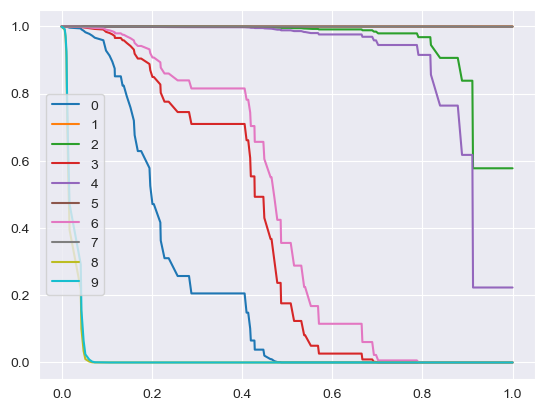

In [13]:
cph.predict_survival_function(final_df.iloc[0:10, :]).plot()

In [ ]:
cph.print_summary()

## Optimism computation

In [14]:
np.random.seed(42)
c_b_boot, c_b_orig = [], []
num_bootstraps = 1000
bootstrap_size = len(final_df)

for i in range(num_bootstraps):
    choices = np.random.choice(np.arange(0, len(final_df)), size=bootstrap_size, replace=True)
    new_df = final_df.iloc[choices]  #sample bootstrap replicate with replacement

    cph = CoxPHFitter(penalizer=0.01)
    cph.fit(new_df, duration_col='OS', event_col='FUS')  #fit on bootstrap

    c = cph.score(new_df, scoring_method="concordance_index")  #score on bootstrap
    c_b_boot.append(c)

    c = cph.score(final_df, scoring_method="concordance_index")  #score on original
    c_b_orig.append(c)

c_b_orig = np.array(c_b_orig)
c_b_boot = np.array(c_b_boot)

In [15]:
o = np.mean(c_b_boot - c_b_orig)
print("measure of optimism: %.3f" % o)

measure of optimism: 0.155


In [16]:
c_final = c_main - o
print("optimism-corrected c-index is %.3f" % c_final)

optimism-corrected c-index is 0.843


# 95% Confidence Intervals


In [17]:
np.random.seed(42)
c_indices = []
num_bootstraps = 1000
bootstrap_size = len(final_df)

cph = CoxPHFitter(penalizer=0.01) #fit on original data
cph.fit(final_df, duration_col='OS', event_col='FUS')

for i in range(num_bootstraps):
    choices = np.random.choice(np.arange(0, len(final_df)), size=bootstrap_size, replace=True)
    new_df = final_df.iloc[choices]

    c_index = cph.score(new_df, scoring_method="concordance_index")
    c_indices.append(c_index)

c_indices.sort()
hi = c_indices[974]
lo = c_indices[24]

print("Confidence interval is: %.3f - %.3f" % (lo, hi))

Confidence interval is: 0.995 - 1.000


In [18]:
print("Adjusting for optimism")
print("Adjusted confidence interval is: %.3f - %.3f" % (lo-o, hi-o))

Adjusting for optimism
Adjusted confidence interval is: 0.840 - 0.845
